In [ ]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
import matplotlib.pyplot as plt

In [ ]:
def load_data(file_path):
    with open(file_path, 'rb') as file:
        A = np.fromfile(file, dtype=np.int16, count=64)
        nrgb = A[2]
        nfft = A[3]
        nci = A[4]
        ipp = A[6]
        print(f"NRGB: {nrgb} NFFT: {nfft}")
        fs = 10**6 / (np.float64(ipp) * np.float64(nci))
        frequency = np.linspace(-fs / 2, fs / 2, nfft)
        datasize = np.uint32(nrgb) * np.uint32(nfft)

        framecount = 0
        file.seek(0,0)
        while True:
            x = np.fromfile(file, dtype=np.int16, count=64)
            x = np.fromfile(file, dtype=np.int32, count=datasize)
            framecount += 1
            if x.size < 128:
                break

        framecount-=1
        spectra = np.zeros((framecount, nrgb, nfft), dtype=np.float64)
        file.seek(0,0)

        for frame in range(framecount):
            print(f"Frame: {frame+1}")
            _ = np.fromfile(file, dtype=np.int16, count=64)
            for rgb in range(nrgb):
                for ft in range(nfft):
                    try:
                        spectra[frame, rgb, ft] = np.fromfile(file=file, dtype=np.int32, count=1)
                    except:
                        None
                m = np.mean(spectra[frame, rgb, :])
                spectra[frame, rgb, :] -= m

        spectra = np.fft.fftshift(spectra, axes=2)
        peaks = np.zeros_like(spectra, dtype = np.float16)
        for frame in range(framecount):
            for rgb in range(nrgb):
                peak = np.argmax(spectra[frame, rgb, :])
                peaks[frame, rgb, peak] = 1

        return spectra, peaks, nfft, framecount, frequency

In [ ]:
def plot_spectra(spectra, peaks, frequency, offset):
    plt.figure(figsize=(14, 8))
    plt.gca().set_facecolor('#000000')
    frame = 0
    for rgb in range(spectra.shape[0]):
        plt.plot(frequency, np.abs(spectra[rgb]) + offset * rgb, color='green')
        peak = np.argmax(peaks[rgb])
        plt.scatter(frequency[peak], np.abs(spectra[rgb, peak]) + offset * rgb, color='red')
    plt.show()

In [ ]:
directory = ''
filename = '4JU2024SHT1.d9'
file_path = os.path.join(directory,filename)
spectra, peaks, nfft, framecount, frequency = load_data(file_path)

NRGB: 140 NFFT: 256
Frame: 1


<ipython-input-2-f6bcad9552d6>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  spectra[frame, rgb, ft] = np.fromfile(file=file, dtype=np.int32, count=1)


Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
Frame: 17
Frame: 18
Frame: 19
Frame: 20
Frame: 21
Frame: 22
Frame: 23
Frame: 24
Frame: 25
Frame: 26
Frame: 27
Frame: 28
Frame: 29
Frame: 30
Frame: 31
Frame: 32
Frame: 33
Frame: 34
Frame: 35
Frame: 36
Frame: 37
Frame: 38
Frame: 39
Frame: 40
Frame: 41
Frame: 42
Frame: 43
Frame: 44
Frame: 45
Frame: 46
Frame: 47
Frame: 48
Frame: 49
Frame: 50
Frame: 51
Frame: 52
Frame: 53
Frame: 54
Frame: 55
Frame: 56
Frame: 57
Frame: 58
Frame: 59
Frame: 60
Frame: 61
Frame: 62
Frame: 63
Frame: 64
Frame: 65
Frame: 66
Frame: 67
Frame: 68
Frame: 69
Frame: 70
Frame: 71
Frame: 72
Frame: 73
Frame: 74
Frame: 75
Frame: 76
Frame: 77
Frame: 78
Frame: 79
Frame: 80
Frame: 81
Frame: 82
Frame: 83
Frame: 84
Frame: 85
Frame: 86
Frame: 87
Frame: 88
Frame: 89
Frame: 90
Frame: 91
Frame: 92
Frame: 93
Frame: 94
Frame: 95
Frame: 96
Frame: 97
Frame: 98
Frame: 99
Frame: 100
Frame: 101
Frame:

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
for frame in range(framecount):
    spectra[frame,:,:] = scaler.fit_transform(spectra[frame,:,:])

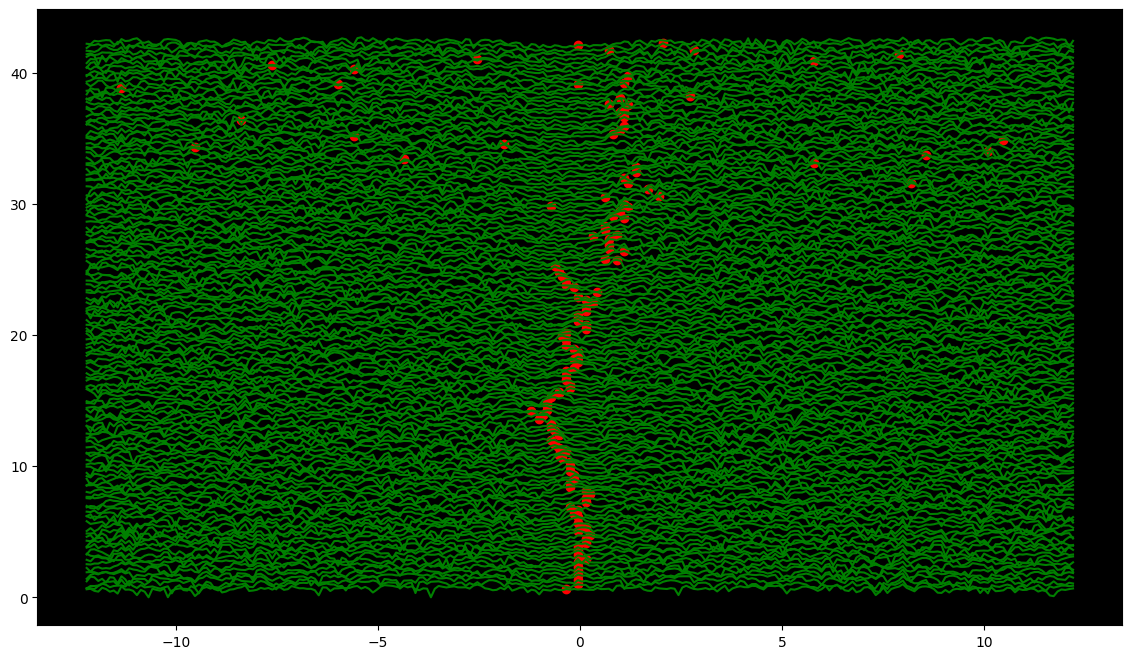

In [ ]:
frame = 140
plot_spectra(spectra[frame], peaks[frame], frequency, 0.3)

In [ ]:
seq_length = 8
range_count = 80
limit_width = 100
left_limit = nfft // 2 - limit_width // 2
right_limit = nfft // 2 + limit_width // 2

In [ ]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(seq_length, limit_width)))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.25))
model.add(TimeDistributed(Dense(limit_width, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 256)              │         365,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 256)              │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 100)              │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 916,580 (3.50 MB)

 Trainable params: 916,580 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(spectra.shape)
print(peaks.shape)

(165, 140, 256)
(165, 140, 256)


In [ ]:
X = np.zeros((framecount*(range_count - seq_length), seq_length, limit_width))
y = np.zeros((framecount*(range_count - seq_length), seq_length, limit_width))
for frame in range(framecount):
    for i in range(range_count - seq_length):
        X[frame*(range_count - seq_length)+i] = spectra[frame, i:i+seq_length, left_limit:right_limit]
        y[frame*(range_count - seq_length)+i] = peaks[frame, i:i+seq_length, left_limit:right_limit]
print(X.shape)
print(y.shape)

(11880, 8, 100)
(11880, 8, 100)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9504, 8, 100)
(9504, 8, 100)
(2376, 8, 100)
(2376, 8, 100)


In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1642 - loss: 2.9386 - val_accuracy: 0.1862 - val_loss: 2.5971
Epoch 2/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.1988 - loss: 2.5239 - val_accuracy: 0.2814 - val_loss: 2.1924
Epoch 3/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2842 - loss: 2.0625 - val_accuracy: 0.3501 - val_loss: 1.8206
Epoch 4/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3475 - loss: 1.8234 - val_accuracy: 0.3612 - val_loss: 1.7691
Epoch 5/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3817 - loss: 1.7011 - val_accuracy: 0.4060 - val_loss: 1.6387
Epoch 6/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4088 - loss: 1.6093 - val_accuracy: 0.4316 - val_loss: 1.5574
Epoch 7/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4111 - loss: 1.5806 - val_accuracy: 0.4323 - val_loss: 1.5209
Epoch 8/200
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4333 - loss: 1.5145 - val_

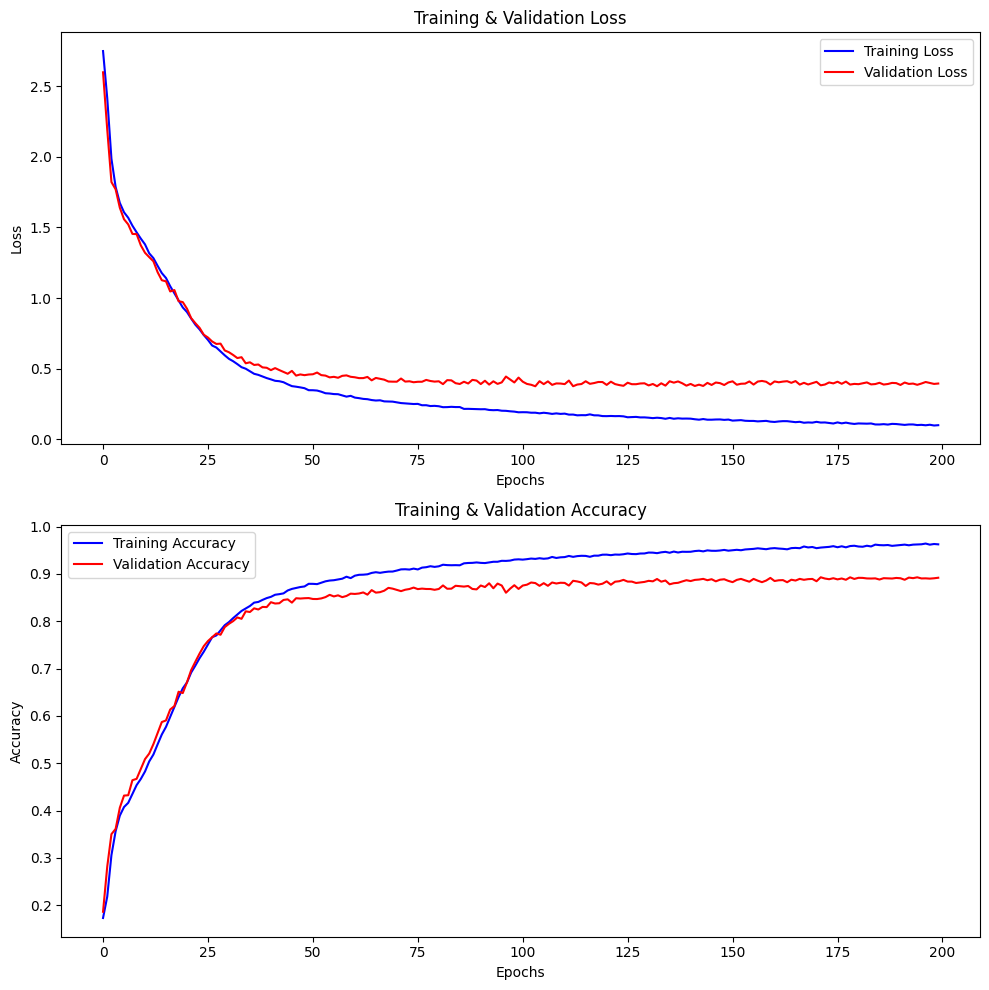

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot Loss
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss")
ax[0].set_title("Training & Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(loc='best')

# Plot Accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
ax[1].set_title("Training & Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(spectra[:,:, left_limit:right_limit])
predicted_peaks = np.argmax(y_pred, axis=-1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


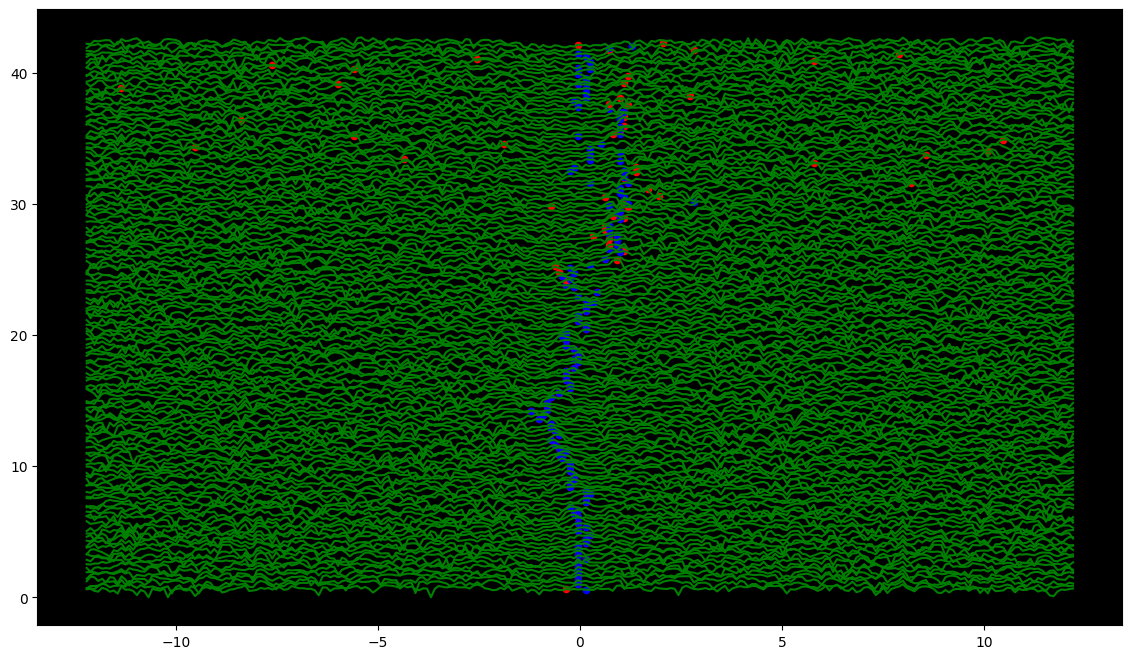

In [ ]:
plt.figure(figsize=(14, 8))
plt.gca().set_facecolor('#000000')
offset = 0.3
frame = 140
for rgb in range(140):
    plt.plot(frequency, np.abs(spectra[frame, rgb]) + offset * rgb, color='green')
    peak = np.argmax(peaks[frame, rgb])
    pred_peak = predicted_peaks[frame, rgb] + left_limit
    plt.scatter(frequency[peak], np.abs(spectra[frame, rgb, peak]) + offset * rgb, color='red', s=20)
    plt.scatter(frequency[pred_peak], np.abs(spectra[frame, rgb, pred_peak]) + offset * rgb, color='blue', s=20)
plt.show()